In [2]:
import torch
import xarray
from datasets import *
from models import *
from dl_pipeline import *
import seaborn
import numpy as np
import matplotlib.pyplot as plt
import copy

In [3]:
train_json_path = '/g/data/x77/ob2720/partition/train.json'
valid_json_path = '/g/data/x77/ob2720/partition/valid.json'
test_json_path = '/g/data/x77/ob2720/partition/test.json'

## Perturbation of Eigenvalues for Synthesis

We start with perturbation of the eigenvectors for synthesising new data from eiegenvalues closest to $0$. We take this perturbation to be sampled from a random distribution around a mean, $\mu$, of $0$, with a standard deviation of $\sigma$.

In [4]:
mu, sigma = 0, 0.001 # mean and standard deviation

In [3]:
train_ds, valid_ds, test_ds = generate_prediction_dataset()

NameError: name 'generate_prediction_dataset' is not defined

In [5]:
def new_example(model,x, perturb=True, sigma=0.001):
    W = model.dynamics.dynamics.weight.cpu().detach().numpy()
    w, v = np.linalg.eig(W)
    min_i = np.argmax(w)
    s = np.random.normal(mu, sigma, len(v[0]))
    
    model_modified = copy.deepcopy(model).to(0)
    
    
    if perturb:
        v[min_i] += s
    W_1 = reconstruct_operator(w,v).real
    
    model_modified.dynamics.dynamics.weight = torch.nn.Parameter(torch.from_numpy(W_1))
    
    model_modified.to(0)
    x_modified = model_modified(x.to(0))
    
    return x_modified

In [6]:
saved_models_path = '/home/156/jm0124/kae-cyclones/saved_models'

model_dae = koopmanAE(16, steps=4, steps_back=4, alpha=16).to(0)
model_dae.load_state_dict(torch.load(f'{saved_models_path}/dae-eigen-2.706214427947998.pt'))
model_dae.to(0)

koopmanAE(
  (encoder): encoderNetSimple(
    (fc1): Linear(in_features=400, out_features=256, bias=True)
    (fc2): Linear(in_features=256, out_features=256, bias=True)
    (fc3): Linear(in_features=256, out_features=16, bias=True)
  )
  (decoder): decoderNetSimple(
    (fc1): Linear(in_features=16, out_features=256, bias=True)
    (fc2): Linear(in_features=256, out_features=256, bias=True)
    (fc3): Linear(in_features=256, out_features=400, bias=True)
  )
  (dynamics): dynamics(
    (dynamics): Linear(in_features=16, out_features=16, bias=False)
  )
  (backdynamics): dynamics_back(
    (dynamics): Linear(in_features=16, out_features=16, bias=False)
  )
)

In [13]:
for i in range(1,20):
    old = train_ds[i*100+1][0].squeeze(0).squeeze(0)
    x_reg = new_example(model_dae,train_ds[i*100][0].to(0), True, sigma=0.2)[0][0].squeeze(0).squeeze(0).cpu().detach().numpy()
    x_per = new_example(model_dae,train_ds[i*100][0].to(0), False, sigma=2)[0][0].squeeze(0).squeeze(0).cpu().detach().numpy()

    seaborn.heatmap(old)
    plt.show()
    seaborn.heatmap(x_reg)
    plt.show()
    seaborn.heatmap(x_per)
    plt.show()

NameError: name 'train_ds' is not defined

### Generation of New Data

In [5]:
def create_modified_model(model, mu, sigma, perturb=True):
    W = model.dynamics.dynamics.weight.cpu().detach().numpy()
    w, v = np.linalg.eig(W)
    max_i = np.argmax(w)
    print(f"Max eigenvalue: {np.max(np.absolute(w))}")
    print(f"Min eigenvalue: {np.min(np.absolute(w))}")
    print(np.absolute(w))
    
    model_modified = copy.deepcopy(model).to(0)
    
    s = np.random.normal(mu, sigma, len(v[0]))
    
    if perturb:
        v[max_i] += s
    W_1 = reconstruct_operator(w,v).real
    
    model_modified.to(0)
    model_modified.dynamics.dynamics.weight = torch.nn.Parameter(torch.from_numpy(W_1))
    print(model_modified.dynamics.dynamics.weight)
    
    return model_modified

In [6]:
mod_model = create_modified_model(model_dae, 0, 0.1).to(0)

Max eigenvalue: 6.847322463989258
Min eigenvalue: 4.957252502441406
[6.5875382 6.5875382 6.7793975 6.6053762 6.6053762 6.461615  6.461615
 6.481649  6.481649  6.5130224 6.5130224 6.662136  6.662136  6.223304
 6.223304  6.32061   6.32061   6.3453083 6.3453083 6.3402386 6.3402386
 6.8147693 6.8147693 6.502285  6.502285  6.1855717 6.1855717 6.7730904
 6.7730904 6.336106  6.336106  6.1776423 6.1776423 6.66242   6.66242
 5.898575  5.898575  6.8063455 6.8063455 6.8473225 6.8473225 6.392312
 6.392312  6.431583  6.431583  6.379235  6.379235  6.4183245 6.4183245
 6.0297446 5.4545403 5.4545403 4.9572525 4.9572525 5.5032425 5.5032425
 5.288476  5.288476  6.253626  6.253626  5.809612  5.809612  5.2625966
 5.2625966]
Parameter containing:
tensor([[-1.0340e+00,  2.4186e-01,  8.5910e-01,  ...,  4.0923e-01,
          4.0490e-01,  2.4862e-01],
        [-7.1670e-01,  6.1313e-01, -9.3878e-02,  ..., -1.6699e-01,
         -1.3004e+00, -1.3979e-01],
        [ 2.1890e-01, -1.3489e+00, -5.9937e-01,  ...,  3.5

In [12]:
A = mod_model.dynamics.dynamics.weight.cpu().detach().numpy()
w, v = np.linalg.eig(A)
w_abs = np.absolute(w)
loss_eigen = (1/w_abs.size) * np.sum(w_abs - 1)
print(w)
print(np.min(np.absolute(w)))
print(np.argmin(np.absolute(w)))

[-6.4873104 +1.1540108j  -6.4873104 -1.1540108j  -6.7793975 +0.j
 -6.6023283 +0.2433621j  -6.6023283 -0.2433621j  -6.0207844 +2.352612j
 -6.0207844 -2.352612j   -5.867302  +2.7680612j  -5.867302  -2.7680612j
 -5.5767975 +3.3596287j  -5.5767975 -3.3596287j  -5.2910366 +4.0360217j
 -5.2910366 -4.0360217j  -5.222129  +3.3554766j  -5.222129  -3.3554766j
 -4.881251  +4.0555387j  -4.881251  -4.0555387j  -3.9436421 +4.9363556j
 -3.9436421 -4.9363556j  -3.6071634 +5.193271j   -3.6071634 -5.193271j
 -2.9101963 +6.169226j   -2.9101963 -6.169226j   -2.307437  +6.021591j
 -2.307437  -6.021591j   -2.3699331 +5.589522j   -2.3699331 -5.589522j
 -0.7889998 +6.741843j   -0.7889998 -6.741843j   -1.129054  +6.228535j
 -1.129054  -6.228535j   -0.16308434+6.2086787j  -0.16308434-6.2086787j
  1.1951269 +5.747648j    1.1951269 -5.747648j    1.9985398 +6.4200296j
  1.9985398 -6.4200296j   2.6085062 +6.274111j    2.6085062 -6.274111j
  3.9966934 +5.5348997j   3.9966934 -5.5348997j   2.9228377 +5.529613j
  2.92

In [21]:
def generate_new_data(model, modified_model, sigma):   
    
    
    train_ds = CycloneDataset('/g/data/x77/ob2720/partition/train/', tracks_path=train_json_path, 
                                            save_np=True, load_np=False)
    val_ds = CycloneDataset('/g/data/x77/ob2720/partition/valid/', tracks_path=valid_json_path, 
                                        save_np=True, load_np=False, partition_name='valid')
    test_ds = CycloneDataset('/g/data/x77/ob2720/partition/test/', tracks_path=test_json_path,
                                         save_np=True, load_np=False, partition_name='test')
    print(len(train_ds))
    print("Train ds")
    # for i,(cyclone_array, cyclone, j) in tqdm(enumerate(train_ds)):
    #     x_reg = model(torch.from_numpy(cyclone_array).to(0))[0][0].cpu().detach().numpy()
    #     np.save(f'/g/data/x77/jm0124/synthetic_datasets/base_synthesis/u/2/{sigma}/train/{cyclone}-{j+1}', x_reg)
    
    for i,(cyclone_array, cyclone, j) in tqdm(enumerate(train_ds)):    
        x_mod = modified_model(torch.from_numpy(cyclone_array).to(0))[0][0].cpu().detach().numpy()
        np.save(f'/g/data/x77/cn1951/synthetic_datasets/normal_perturb_synthesis/u/2/{sigma}/train/{cyclone}-{j+1}', x_mod)

In [22]:
generate_new_data(model_dae, mod_model, '0.1')

191235
Train ds


0it [00:00, ?it/s]


FileNotFoundError: [Errno 2] No such file or directory: '/g/data/x77/cn1951/synthetic_datasets/normal_perturb_synthesis/u/2/0.1/train/1999258N25128-2.npy'

In [14]:
print(train_ds[130][0].shape)

torch.Size([1, 1, 20, 20])


In [23]:
data = np.load('/g/data/x77/jm0124/synthetic_datasets/normal_perturb_synthesis/u/2/train/1999258N25128-3.npy')
data2 = np.load('/g/data/x77/jm0124/synthetic_datasets/base_synthesis/u/2/train/1999258N25128-3.npy')

FileNotFoundError: [Errno 2] No such file or directory: '/g/data/x77/jm0124/synthetic_datasets/normal_perturb_synthesis/u/2/train/1999258N25128-3.npy'

In [13]:
def fixed_point(x, t, mu, lam): 
    # The simple pendulum subject to zero damping and zero control input 
    nx = np.zeros(2)
    x1, x2 = x[0], x[1]
    nx[0] = mu * x1
    nx[1] = lam * (x2 - x1**2)
    return nx

In [6]:
def unforced_duffing(x, t, delta, beta,alpha): 
    # The simple pendulum subject to zero damping and zero control input 
    nx = np.zeros(2)
    x1, x2 = x[0], x[1]
    nx[0] = x2
    nx[1] = - delta * x2 - x1 * (beta + alpha * x1**2)
    return nx

In [7]:
import numpy as np
from tqdm import tqdm
from scipy.integrate import odeint

In [8]:
sols_duffing_train, sols_duffing_val, sols_duffing_test = [], [], []
positions_train = np.random.uniform(low=-0.5, high=0.5, size=(1600,2))
positions_val = np.random.uniform(low=-0.5, high=0.5, size=(400,2))
positions_test = np.random.uniform(low=-0.5, high=0.5, size=(400,2))
for start_pos in tqdm(positions_train):
    part_c = []
    t_span = np.linspace(0,10,50)
    sol = odeint(unforced_duffing, y0=start_pos, t=t_span, args=(0.5,-1,1))
    sols_duffing_train.append(sol)

for start_pos in tqdm(positions_val):
    part_c = []
    t_span = np.linspace(0,10,50)
    sol = odeint(unforced_duffing, y0=start_pos, t=t_span, args=(0.5,-1,1))
    sols_duffing_val.append(sol)

for start_pos in tqdm(positions_test):
    part_c = []
    t_span = np.linspace(0,10,50)
    sol = odeint(unforced_duffing, y0=start_pos, t=t_span, args=(0.5,-1,1))
    sols_duffing_test.append(sol)

100%|██████████| 400/400 [00:00<00:00, 1771.52it/s]


In [9]:
sols_duffing_train = np.array(sols_duffing_train)
sols_duffing_val = np.array(sols_duffing_val)
sols_duffing_test = np.array(sols_duffing_test)

In [10]:
sols_duffing_train.shape

(1600, 50, 2)

(1600, 50, 2)


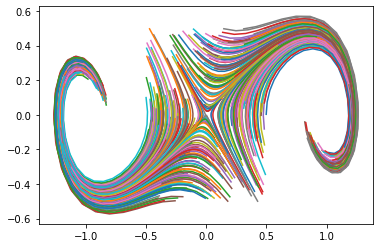

In [11]:
import matplotlib.pyplot as plt
sols = np.array(sols_duffing_train)
print(sols_duffing_train.shape)
for i in range(0,400):
    plt.plot(sols_duffing_val[i,0:20,0], sols_duffing_val[i,0:20,1])

In [19]:
fp_sols_train, fp_sols_val, fp_sols_test = [], [], []
fp_train = np.random.uniform(low=-0.5, high=0.5, size=(1600,2))
fp_val = np.random.uniform(low=-0.5, high=0.5, size=(400,2))
fp_test = np.random.uniform(low=-0.5, high=0.5, size=(400,2))
for start_pos in tqdm(fp_train):
    part_c = []
    t_span = np.linspace(0,3,25)
    sol = odeint(fixed_point, y0=start_pos, t=t_span, args=(-0.05,-1))
    fp_sols_train.append(sol)

for start_pos in tqdm(fp_val):
    part_c = []
    t_span = np.linspace(0,3,25)
    sol = odeint(fixed_point, y0=start_pos, t=t_span, args=(-0.05,-1))
    fp_sols_val.append(sol)

for start_pos in tqdm(fp_test):
    part_c = []
    t_span = np.linspace(0,3,25)
    sol = odeint(fixed_point, y0=start_pos, t=t_span, args=(-0.05,-1))
    fp_sols_test.append(sol)

100%|██████████| 400/400 [00:00<00:00, 5738.43it/s]


In [20]:
fp_sols_train = np.array(fp_sols_train)
fp_sols_val = np.array(fp_sols_val)
fp_sols_test = np.array(fp_sols_test)

(1600, 25, 2)


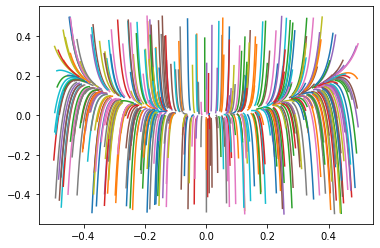

In [21]:
import matplotlib.pyplot as plt
sols = np.array(fp_sols_train)
print(fp_sols_train.shape)
for i in range(0,400):
    plt.plot(fp_sols_train[i,0:500,0], fp_sols_train[i,0:500,1])

In [22]:
!ls /g/data/x77/jm0124/synthetic_datasets/pendulum_dissipative-2.0-5.npy

/g/data/x77/jm0124/synthetic_datasets/pendulum_dissipative-2.0-5.npy


In [23]:
array = np.load('/g/data/x77/jm0124/synthetic_datasets/pendulum_dissipative-2.0-5.npy')

In [24]:
array.shape

(5, 400, 150, 2)

In [25]:
sols.shape

(1600, 25, 2)

In [26]:
np.save('/g/data/x77/jm0124/synthetic_datasets/fp_attractor_train.npy', fp_sols_train)
np.save('/g/data/x77/jm0124/synthetic_datasets/fp_attractor_val.npy', fp_sols_val)
np.save('/g/data/x77/jm0124/synthetic_datasets/fp_attractor_test.npy', fp_sols_test)

In [27]:
np.save('/g/data/x77/jm0124/synthetic_datasets/sols_duffing_train.npy', sols_duffing_train)
np.save('/g/data/x77/jm0124/synthetic_datasets/sols_duffing_val.npy', sols_duffing_val)
np.save('/g/data/x77/jm0124/synthetic_datasets/sols_duffing_test.npy', sols_duffing_test)

In [42]:
fp_train = np.load('/g/data/x77/jm0124/synthetic_datasets/sols_duffing_train.npy')

In [61]:
fp_train.shape

(1600, 500, 2)

In [43]:
fp_sols_train, fp_sols_val, fp_sols_test = [], [], []
fp_train = np.random.uniform(low=-0.1, high=0.1, size=(400,2))
fp_val = np.random.uniform(low=-0.1, high=0.1, size=(36,2))
fp_test = np.random.uniform(low=-0.1, high=0.1, size=(36,2))
for start_pos in tqdm(fp_train):
    part_c = []
    t_span = np.linspace(0,3,500)
    sol = odeint(fixed_point, y0=start_pos, t=t_span, args=(-0.05,-1))
    fp_sols_train.append(sol)

for start_pos in tqdm(fp_val):
    part_c = []
    t_span = np.linspace(0,3,500)
    sol = odeint(fixed_point, y0=start_pos, t=t_span, args=(-0.05,-1))
    fp_sols_val.append(sol)

for start_pos in tqdm(fp_test):
    part_c = []
    t_span = np.linspace(0,3,500)
    sol = odeint(fixed_point, y0=start_pos, t=t_span, args=(-0.05,-1))
    fp_sols_test.append(sol)

100%|██████████| 36/36 [00:00<00:00, 5638.14it/s]


In [46]:
fp_sols_train_small = np.array(fp_sols_train)
fp_sols_val_small = np.array(fp_sols_val)
fp_sols_test_small = np.array(fp_sols_test)

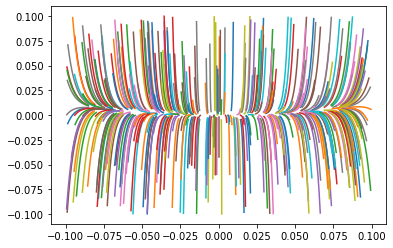

In [47]:
import matplotlib.pyplot as plt
for i in range(0,400):
    plt.plot(fp_sols_train_small[i,0:500,0], fp_sols_train_small[i,0:500,1])

In [70]:
10*fp_sols_train_small[5][4]

array([-0.19123735, -0.47837217])

In [49]:
np.save('/g/data/x77/jm0124/synthetic_datasets/fp_attractor_train_small.npy', fp_sols_train_small)
np.save('/g/data/x77/jm0124/synthetic_datasets/fp_attractor_val_small.npy', fp_sols_val_small)
np.save('/g/data/x77/jm0124/synthetic_datasets/fp_attractor_test_small.npy', fp_sols_test_small)

In [ ]:
"""
sols_duffing_train, sols_duffing_val, sols_duffing_test = [], [], []
positions_train = np.random.uniform(low=-0.5, high=0.5, size=(1600,2))
positions_val = np.random.uniform(low=-0.5, high=0.5, size=(400,2))
positions_test = np.random.uniform(low=-0.5, high=0.5, size=(400,2))
for start_pos in tqdm(positions_train):
    part_c = []
    t_span = np.linspace(0,200,500)
    sol = odeint(unforced_duffing, y0=start_pos, t=t_span, args=(-0.05,-1))
    sols_duffing_train.append(sol)

for start_pos in tqdm(positions_val):
    part_c = []
    t_span = np.linspace(0,200,500)
    sol = odeint(unforced_duffing, y0=start_pos, t=t_span, args=(-0.05,-1))
    sols_duffing_val.append(sol)

for start_pos in tqdm(positions_test):
    part_c = []
    t_span = np.linspace(0,200,500)
    sol = odeint(unforced_duffing, y0=start_pos, t=t_span, args=(-0.10,-1))
    sols_duffing_test.append(sol)
"""